# FERM356 - Demystifying Turkish Economic Data - Assignment IV: FX Passthrough

### INSTRUCTION - Use the provided “CPI_All_March2024.csv” Data file provided for this Assignment

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.regression.rolling import RollingOLS

import warnings
warnings.filterwarnings("ignore")

C:\Users\emir.e\Anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## a) TRY Basket Passthrough on CPI
## - Estimate the relationship between the monthly seasonally adjusted CPI changes (CPI_SA) and TRY Basket changes.

In [2]:
df=pd.read_csv("CPI_All_March2024.csv",index_col="Month")
df.index=pd.to_datetime(df.index)
df

,CPI_SA,Core_SA,Services_SA,PPI_SA,CoreGoods_SA,PPI_Mfg_SA,USDTRY,EURTRY
Month,,,,,,,,
2003-01-01,94.496018,95.154148,93.003485,94.318481,96.116364,98.217654,1.659829,1.760544
2003-02-01,95.971867,96.626121,94.218492,97.282867,97.311128,100.074652,1.627145,1.754147
2003-03-01,97.551628,97.816864,95.564773,100.400298,98.311239,101.858631,1.659379,1.792435
2003-04-01,98.423702,98.585492,96.820349,102.167899,99.078875,100.489287,1.631121,1.767996
2003-05-01,99.294378,99.137006,98.107806,101.533658,99.125696,98.351026,1.493972,1.720026
...,...,...,...,...,...,...,...,...
2023-10-01,1761.497370,1577.963769,1696.204691,2803.290000,1095.750048,2689.500000,27.821073,29.383195
2023-11-01,1819.562623,1630.309610,1785.775536,2882.040000,1123.086177,2750.150000,28.611334,30.874732
2023-12-01,1880.172281,1691.448408,1867.537372,2915.020000,1157.638324,2805.260000,29.048710,31.686364


### Month: The date column, formatted as YYYY-MM-DD, set as index
### CPI_SA: Consumer Price Index, seasonally adjusted.
### Core_SA: Core inflation index, excluding volatile items like food and energy, seasonally adjusted.
### Services_SA: Services component of the CPI, seasonally adjusted.
### PPI_SA: Producer Price Index, seasonally adjusted.
### CoreGoods_SA: Core goods index, presumably excluding food and energy, seasonally adjusted.
### PPI_Mfg_SA: Producer Price Index for manufacturing, seasonally adjusted.
### USDTRY: Exchange rate between the US dollar and Turkish lira.
### EURTRY: Exchange rate between the Euro and Turkish lira.

In [3]:
# Convert all columns to numeric
df = df.apply(pd.to_numeric)

# Create a new column 'Basket' that is the average of 'USDTRY' and 'EURTRY' exchange rates
df["Basket"]=df[['USDTRY','EURTRY']].mean(axis=1)

runlist=['Basket','CPI_SA','PPI_SA',"USDTRY","EURTRY"]

# Loop through each column in the runlist to apply transformations
for x in runlist:
    # Calculate the percentage change from the previous row
    df['g'+x]=df[x].pct_change(periods=1)*100
    
    # Create lagged variables for 1 to 5 periods back for each column in the runlist
    for i in range(1,6):
        df['g'+x+str(i)]=df['g'+x].shift(i)
df

,CPI_SA,Core_SA,Services_SA,PPI_SA,CoreGoods_SA,PPI_Mfg_SA,USDTRY,EURTRY,Basket,gBasket,...,gUSDTRY2,gUSDTRY3,gUSDTRY4,gUSDTRY5,gEURTRY,gEURTRY1,gEURTRY2,gEURTRY3,gEURTRY4,gEURTRY5
Month,,,,,,,,,,,,,,,,,,,,,
2003-01-01,94.496018,95.154148,93.003485,94.318481,96.116364,98.217654,1.659829,1.760544,1.710187,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-02-01,95.971867,96.626121,94.218492,97.282867,97.311128,100.074652,1.627145,1.754147,1.690646,-1.142580,...,NaN,NaN,NaN,NaN,-0.363361,NaN,NaN,NaN,NaN,NaN
2003-03-01,97.551628,97.816864,95.564773,100.400298,98.311239,101.858631,1.659379,1.792435,1.725907,2.085625,...,NaN,NaN,NaN,NaN,2.182695,-0.363361,NaN,NaN,NaN,NaN
2003-04-01,98.423702,98.585492,96.820349,102.167899,99.078875,100.489287,1.631121,1.767996,1.699558,-1.526666,...,-1.969081,NaN,NaN,NaN,-1.363474,2.182695,-0.363361,NaN,NaN,NaN
2003-05-01,99.294378,99.137006,98.107806,101.533658,99.125696,98.351026,1.493972,1.720026,1.606999,-5.446069,...,1.980979,-1.969081,NaN,NaN,-2.713196,-1.363474,2.182695,-0.363361,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,1761.497370,1577.963769,1696.204691,2803.290000,1095.750048,2689.500000,27.821073,29.383195,28.602134,2.495259,...,1.997669,14.560250,17.173497,1.977981,1.860732,-2.066730,0.769087,17.077284,16.423419,1.307795
2023-11-01,1819.562623,1630.309610,1785.775536,2882.040000,1123.086177,2750.150000,28.611334,30.874732,29.743033,3.988859,...,-0.035844,1.997669,14.560250,17.173497,5.076154,1.860732,-2.066730,0.769087,17.077284,16.423419
2023-12-01,1880.172281,1691.448408,1867.537372,2915.020000,1157.638324,2805.260000,29.048710,31.686364,30.367537,2.099665,...,3.174054,-0.035844,1.997669,14.560250,2.628792,5.076154,1.860732,-2.066730,0.769087,17.077284


In [4]:
# Create the TRY Basket column as the average of USDTRY and EURTRY
df['TRY_Basket'] = df[['USDTRY', 'EURTRY']].mean(axis=1)

# Calculate monthly percentage changes for CPI_SA and TRY Basket
df['CPI_SA_Change'] = df['CPI_SA'].pct_change() * 100  
df['TRY_Basket_Change'] = df['TRY_Basket'].pct_change() * 100

# Drop the NaN values that result from the pct_change calculation
df_clean = df.dropna()

# Define the independent variable (X) and the dependent variable (y)
X = df_clean[['TRY_Basket_Change']]  
y = df_clean['CPI_SA_Change']  

# Add a constant to the independent variable to include the intercept in the regression
X = sm.add_constant(X)

# Create the linear regression model
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          CPI_SA_Change   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     73.78
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           1.02e-15
Time:                        11:08:05   Log-Likelihood:                -448.25
No. Observations:                 248   AIC:                             900.5
Df Residuals:                     246   BIC:                             907.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.9840      0.09

### COMMENT: The regression output indicates a significant relationship between the TRY Basket changes and CPI SA changes, with the p-value well below the 5% significance level, underscoring the importance of TRY Basket changes as a predictor. The coefficient for TRY Basket changes stands at 0.1945, suggesting that a 1% increase in the TRY Basket correlates with a 0.1945% increase in CPI SA, all else being constant. The model explains about 23.1% of the variation in CPI SA changes, as shown by the R-squared value, leaving a significant portion unexplained and pointing to the potential influence of other variables not captured by the model.

### The model's fit is confirmed by the F-statistic, but the diagnostics indicate possible issues. The Durbin-Watson statistic of 0.747 suggests the presence of positive autocorrelation in the residuals, hinting that the model may not be capturing all relevant information. The high Jarque-Bera statistic indicates non-normal distribution of residuals, a common feature in macroeconomic datasets. These findings suggest the model could be refined by adding more variables or addressing the issues of autocorrelation and non-normality in residuals.

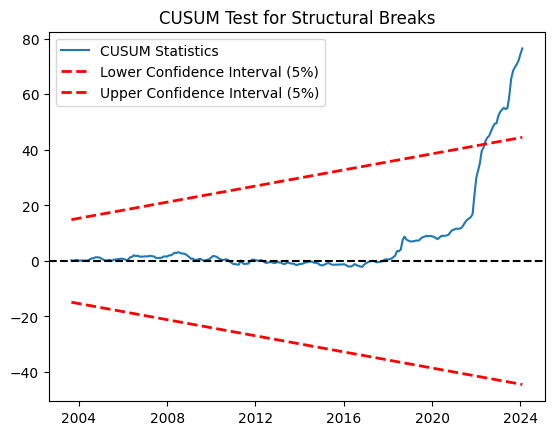

In [5]:
# Obtain CUSUM statistics and confidence intervals using recursive residuals
rcusum = sm.stats.diagnostic.recursive_olsresiduals(results)[5]
rcusumci = sm.stats.diagnostic.recursive_olsresiduals(results)[6]

# Determine the number of observations in the model
nobs = int(model.nobs)

# Calculate the number of initial observations to exclude.
# Recursive residuals are not available for the initial observations due to the nature of the calculation.
exskip = len(df.index) - nobs

# Calculate the total number of observations to skip.
nskip = int(1 + model.df_model + exskip)

# Create a new index for plotting that aligns with the available CUSUM statistics.
index_new = df.index.copy()
index_new = index_new[nskip:]

# Begin plotting the CUSUM statistics and confidence intervals
plt.plot(index_new, rcusum[1:len(rcusum)], label='CUSUM Statistics')
plt.plot(index_new, rcusumci[0], 'r--', label='Lower Confidence Interval (5%)', linewidth=2)
plt.plot(index_new, rcusumci[1], 'r--', label='Upper Confidence Interval (5%)', linewidth=2)
plt.axhline(0, color='black', linestyle='--')

plt.title("CUSUM Test for Structural Breaks")
plt.legend()
plt.show()

### COMMENT: The CUSUM test is employed to detect shifts within time series data, useful for identifying instability, such as fluctuations in regression coefficients. By aggregating residuals over time, it assesses whether cumulative errors surpass a critical threshold, signaling structural change. In the depicted CUSUM chart, the upward-trending green line (cumulative recursive residuals) breaching the blue 5% significance lines suggests a potential structural break post-2020, potentially linked to significant economic events. This deviation from the zero line (black dashed) indicates a change in the relationship between CPI and TRY Basket changes, hinting at the need for model reassessment to account for evolving economic dynamics.

## - Check if there is a need for using dummies

In [6]:
# Create a dummy variable that equals 1 for observations from 2020 onwards, and 0 otherwise
df['PostChange'] = (df.index.year >= 2020).astype(int)

# Re-run the regression with the additional dummy variable to capture the effect of the structural change
model2 = smf.ols('CPI_SA_Change ~ TRY_Basket_Change + PostChange', data=df).fit()

# Print the summary of the new model to examine the impact of the dummy variable
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:          CPI_SA_Change   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     98.70
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           2.54e-32
Time:                        11:08:16   Log-Likelihood:                -414.44
No. Observations:                 253   AIC:                             834.9
Df Residuals:                     250   BIC:                             845.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6672      0.08

### COMMENT: The updated regression shows distinct coefficients for gBasket before and after 2020, indicating a marked change in the relationship with gCPI_SA starting in that year. Specifically, the gBasket coefficient rises substantially in the post-2020 period, with the change deemed statistically significant given the p-value well below the 5% threshold. The model's explanatory power, as measured by R-squared values, has notably improved with the inclusion of the dummy variable. This underscores the relevance of the dummy in capturing shifts in the data and substantiates the presence of a structural break that must be considered in subsequent analysis and forecasting.

## - Try including lagged dependent and lagged TRY basket changes

In [7]:
# Let's create lagged variables for dependent variable the CPI SA and independent variable TRY Basket.
# Let's use only one lag
number_of_lags = 1  

for i in range(1, number_of_lags + 1):
    df['CPI_SA_Lagged' + str(i)] = df['CPI_SA_Change'].shift(i)
    df['Basket_Lagged' + str(i)] = df['TRY_Basket_Change'].shift(i)

# Let's remove the rows with NaN values that result from lagging
df = df.dropna()

# And update the regression model to include the lagged variables
model3 = smf.ols(formula='CPI_SA_Change ~ TRY_Basket_Change + Basket_Lagged1 + CPI_SA_Lagged1', data=df).fit()

# Print out the summary to check the significance of the lagged variables
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:          CPI_SA_Change   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     182.6
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           4.47e-62
Time:                        11:08:18   Log-Likelihood:                -334.81
No. Observations:                 248   AIC:                             677.6
Df Residuals:                     244   BIC:                             691.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2080      0.07

### COMMENTS: This regression output reveals a significant relationship between CPI_SA changes and the TRY Basket's current and lagged changes, with notable persistence in CPI_SA changes over time. R-squared (0.689) indicates the model explains around 68.9% of the variance in CPI_SA changes, suggesting a good fit.  Current TRY Basket changes (0.1565) and its lag (0.0502) are both significant predictors of CPI_SA changes, indicating immediate and delayed effects. The lagged CPI_SA change (0.6187) shows strong autocorrelation, emphasizing past CPI_SA's influence on current changes. The F-statistic (<0.001) confirms the model's overall significance. Durbin-Watson (2.030) suggests minimal autocorrelation in residuals, aligning with regression assumptions. Low p-values in Omnibus and Jarque-Bera tests indicate non-normal residuals, hinting at potential data outliers or skewness.

### In essence, the model effectively captures the dynamics between CPI_SA changes and TRY Basket changes, with evidence of a structural relationship. However, the non-normality of residuals suggests the need for further diagnostics or model refinement.

## - What can you say about the impact of 1% rise in TRY basket on CPI in the long-run? 

In [8]:
long_term_effect =  model3.params['TRY_Basket_Change'] + model3.params['Basket_Lagged1'] 
print(f'Long term effect: {long_term_effect:.4f}')

Long term effect: 0.2107


### COMMENTS: For the long-term analysis, considering only the first lag of the TRY Basket, the combined effect of current and lagged TRY Basket changes on CPI_SA changes amounts to 0.2107. This implies that a 1% cumulative increase in the TRY Basket over the current and previous periods leads to a 0.2107% increase in CPI_SA changes, highlighting a positive long-term relationship between these variables.

In [9]:
# Let's try with 2 lags now
number_of_lags = 2 

for i in range(1, number_of_lags + 1):
    df['CPI_SA_Lagged' + str(i)] = df['CPI_SA_Change'].shift(i)
    df['Basket_Lagged' + str(i)] = df['TRY_Basket_Change'].shift(i)

# Let's remove the rows with NaN values that result from lagging
df = df.dropna()

# And update the regression model to include the lagged variables
model4 = smf.ols(formula='CPI_SA_Change ~ TRY_Basket_Change + Basket_Lagged1 + Basket_Lagged2 + CPI_SA_Lagged1 + CPI_SA_Lagged2', data=df).fit()

# Print out the summary to check the significance of the lagged variables
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:          CPI_SA_Change   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     182.6
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           4.47e-62
Time:                        11:08:23   Log-Likelihood:                -334.81
No. Observations:                 248   AIC:                             677.6
Df Residuals:                     244   BIC:                             691.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2080      0.07

### COMMENTS: P values are statistically insignificant in model4 where we checked for 2 lags, so we opt for 1 lag model3.

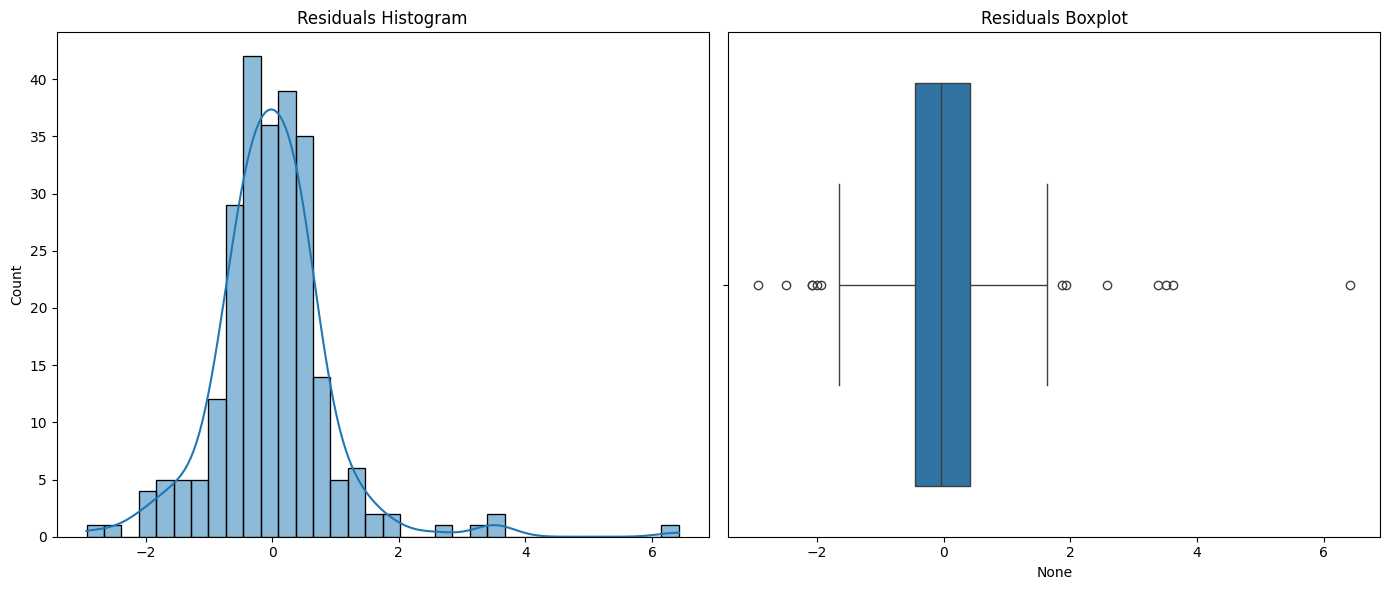

In [10]:
residuals = model3.resid

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Residuals Histogram')

plt.subplot(1, 2, 2)
sns.boxplot(x=residuals)
plt.title('Residuals Boxplot')

plt.tight_layout()
plt.show()

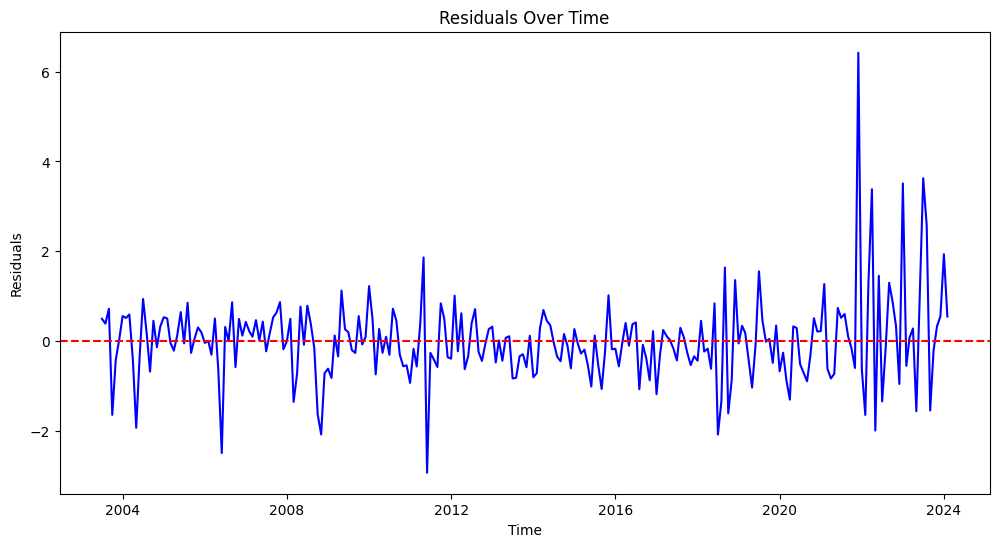

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.show()

### COMMENTS: There seem to be some anomalies and spikes during 2007, 2011, 2018 and 2021-2022 shown in the plot.

<Figure size 1000x600 with 0 Axes>

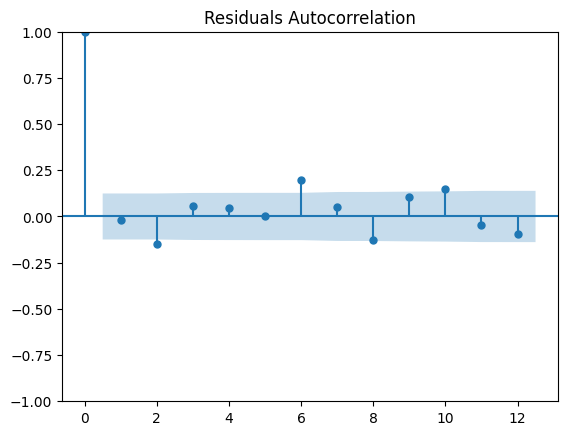

<Figure size 1000x600 with 0 Axes>

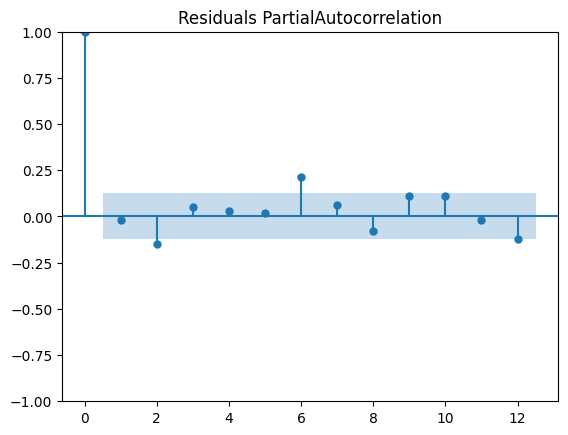

In [12]:
plt.figure(figsize=(10, 6))
plot_acf(residuals, alpha=0.05, lags=12)
plt.title('Residuals Autocorrelation')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(residuals, alpha=0.05, lags=12)
plt.title('Residuals PartialAutocorrelation')
plt.show()

### COMMENTS:The autocorrelation and partial autocorrelation plots indicate significant autocorrelation at certain lags, as evidenced by bars extending outside the blue confidence interval. This suggests that our model may not fully capture all the underlying time series dynamics, or there could be unaddressed seasonal patterns, as indicated by the significant autocorrelation at specific lags.

In [13]:
lb_test = acorr_ljungbox(residuals, lags=[12], model_df=9)
print(lb_test)

      lb_stat     lb_pvalue
12  33.613445  2.390658e-07


### COMMENTS: The Ljung-Box test applied to the model's residuals aims to detect any remaining patterns not captured by the model. Ideally, residuals should resemble white noise, indicating that the model has effectively incorporated the data's underlying structures. In this context, the null hypothesis (H0) shows that the residuals are white noise, while the alternative hypothesis suggests otherwise. Given that the p-value from the Ljung-Box test is significantly below the 5% threshold, we reject H0, implying that the residuals are not white noise. This suggests that our model may not fully account for all the dynamics present in the dataset.

## b) EURTRY vs. USDTRY changes
## - Using OLS, estimate the impact of USDTRY and EURTRY shocks on Turkey’s Inflation process.


In [14]:
model5=smf.ols(formula='gCPI_SA~gEURTRY+gUSDTRY',data=df)
res5=model5.fit()
print(res5.summary())

                            OLS Regression Results                            
Dep. Variable:                gCPI_SA   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     36.06
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           1.93e-14
Time:                        11:08:34   Log-Likelihood:                -445.78
No. Observations:                 246   AIC:                             897.6
Df Residuals:                     243   BIC:                             908.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9839      0.100      9.851      0.0

### COMMENTS: The p-values for both gEURTRY and gUSDTRY are statistically significant, indicating their relevance in the model. The coefficient for gEURTRY is larger than that of gUSDTRY, suggesting it has a marginally more pronounced impact on CPI SA compared to the influence exerted by gUSDTRY.

## - Which currency pair seems to have more significant impact?

In [15]:
modtext='gCPI_SA~gEURTRY+gEURTRY1+gUSDTRY+gUSDTRY1'
model6=smf.ols(formula=modtext,data=df)
res6=model6.fit()
print(res6.summary())

                            OLS Regression Results                            
Dep. Variable:                gCPI_SA   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     41.36
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           2.24e-26
Time:                        11:08:36   Log-Likelihood:                -413.47
No. Observations:                 246   AIC:                             836.9
Df Residuals:                     241   BIC:                             854.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8277      0.090      9.209      0.0

### COMMENTS: The statistical significance of the p-value for the first lag of EURTRY (EURTRY1) stands out, while the p-values for USDTRY, its first lag (USDTRY1), and EURTRY in the current period don't reach statistical significance. This implies that lagged changes in EURTRY have a more substantial effect on CPI SA compared to changes in USDTRY. The model, with an Adjusted R-squared of 0.397, accounts for nearly 39.7% of the variation in gCPI_SA, which is fairly effective for economic data modeling. The Durbin-Watson statistic at 0.742 points to the presence of positive autocorrelation among the residuals, suggesting a potential breach of OLS assumptions that might need addressing. Additionally, the Jarque-Bera test's result (p < 0.05) raises concerns about the normality of residuals, impacting the robustness of certain model statistics. The model's overall significance is confirmed by an F-statistic of 41.36 and a highly significant p-value (2.24e-26), underscoring the model's validity. In essence, the analysis indicates a more significant impact of EURTRY fluctuations on Turkey's inflation dynamics compared to those from USDTRY.

In [16]:
# check if sum of coefficients of EUR and USD are different from zero

print("\n Wald test of sum of EUR Coefficients<>0: ")
print(res6.wald_test('(gEURTRY+gEURTRY1 = 0)',scalar=True))
print("\n Wald test of sum of USD Coefficients<>0: ")
print(res6.wald_test('(gUSDTRY+gUSDTRY1 = 0)',scalar=True))


 Wald test of sum of EUR Coefficients<>0: 
<F test: F=10.340948137233113, p=0.0014792148717463795, df_denom=241, df_num=1>

 Wald test of sum of USD Coefficients<>0: 
<F test: F=8.92060802966698, p=0.0031106987309875455, df_denom=241, df_num=1>


### COMMENTS: The Wald test's p-value indicates that the combined coefficients of gEURTRY and its lag (gEURTRY1) along with gUSDTRY and its lag (gUSDTRY1) are statistically significant, demonstrating that their collective effect is distinguishably different from zero.

## - Do you see a material difference in your conclusion before and after 2020? 

In [17]:
# Let's start with splitting the data as pre-2020 and post-2020
df_pre2020 = df[df.index.year < 2020]
df_post2020 = df[df.index.year >= 2020]

# OLS regression for pre-2020
model_pre2020 = smf.ols(formula=modtext, data=df_pre2020).fit()

# OLS regression for post-2020
model_post2020 = smf.ols(formula=modtext, data=df_post2020).fit()

summary_pre2020 = model_pre2020.summary()
summary_post2020 = model_post2020.summary()

In [18]:
print(summary_pre2020)

                            OLS Regression Results                            
Dep. Variable:                gCPI_SA   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     18.34
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           9.11e-13
Time:                        11:08:40   Log-Likelihood:                -169.24
No. Observations:                 196   AIC:                             348.5
Df Residuals:                     191   BIC:                             364.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6579      0.043     15.272      0.0

In [19]:
print(summary_post2020)

                            OLS Regression Results                            
Dep. Variable:                gCPI_SA   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     14.86
Date:                Mon, 25 Mar 2024   Prob (F-statistic):           8.15e-08
Time:                        11:08:40   Log-Likelihood:                -100.68
No. Observations:                  50   AIC:                             211.4
Df Residuals:                      45   BIC:                             220.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6286      0.344      4.729      0.0

### COMMENTS: Before 2020: The model's Adjusted R-squared of 0.262 indicates it accounts for 26.2% of CPI variation pre-2020. The lagged EUR/TRY exchange rate change (gEURTRY1) shows a notable impact on CPI inflation with statistical significance, whereas the current and lagged USD/TRY rates do not demonstrate significant effects.

### After 2020: An improved Adjusted R-squared of 0.531 suggests the model captures 53.1% of CPI variation post-2020, reflecting enhanced model performance. While most coefficients lack statistical significance at the 5% level, the lagged USD/TRY change (gUSDTRY1) approaches significance, hinting at its potential influence on CPI inflation during this timeframe, potentially reaching significance at the 10% level.

### Overall, the analysis suggests a shift in how exchange rate fluctuations impact Turkey's inflation across the two periods, with post-2020 showing a nuanced influence of lagged USD/TRY changes on inflation, despite a general lack of strong statistical significance in the latter period's model coefficients.

## c) Is FX Pass-through asymmetric?
## - Check whether there is an asymmetry in the response of inflation to FX depreciations/appreciations
## – Do TRY basket depreciations have bigger impact than appreciations?
## – Do you observe any change over time?

In [20]:
df['gBasket_apr']=df['gBasket']*(df['gBasket']<0)
df['gBasket_dep']=df['gBasket']*(df['gBasket']>0)

model6=smf.ols(formula='gCPI_SA~gBasket_apr+gBasket_dep',data=df)
res6=model6.fit()
print(df[['gBasket','gBasket_apr','gBasket_dep']])
print(res6.summary())

             gBasket  gBasket_apr  gBasket_dep
Month                                         
2003-09-01 -1.671675    -1.671675    -0.000000
2003-10-01  6.100357     0.000000     6.100357
2003-11-01  3.384759     0.000000     3.384759
2003-12-01 -0.238549    -0.238549    -0.000000
2004-01-01 -4.474360    -4.474360    -0.000000
...              ...          ...          ...
2023-10-01  2.495259     0.000000     2.495259
2023-11-01  3.988859     0.000000     3.988859
2023-12-01  2.099665     0.000000     2.099665
2024-01-01  3.417179     0.000000     3.417179
2024-02-01  1.732574     0.000000     1.732574

[246 rows x 3 columns]
                            OLS Regression Results                            
Dep. Variable:                gCPI_SA   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     39.19
Date:                Mon, 25 Mar 2024   Prob (F-s

### COMMENTS: The p-value for gBasket_apr exceeds the 5% significance threshold, indicating its effect on CPI SA changes is not statistically meaningful. Conversely, gBasket_dep demonstrates a significant p-value within the 5% level, with a positive coefficient of 0.2296, suggesting a notable influence on CPI SA changes. Specifically, a 1% rise in gBasket_dep is associated with a 0.2296% increase in CPI SA, implying inflationary pressures. This scenario highlights a potential asymmetry in how currency valuation changes impact inflation: depreciation may fuel inflation due to costlier imports, whereas appreciation doesn't necessarily lead to equivalent deflation. This asymmetry could stem from various factors, such as market pricing strategies, the economic framework, and the intricacies of how currency fluctuations translate into consumer price adjustments.

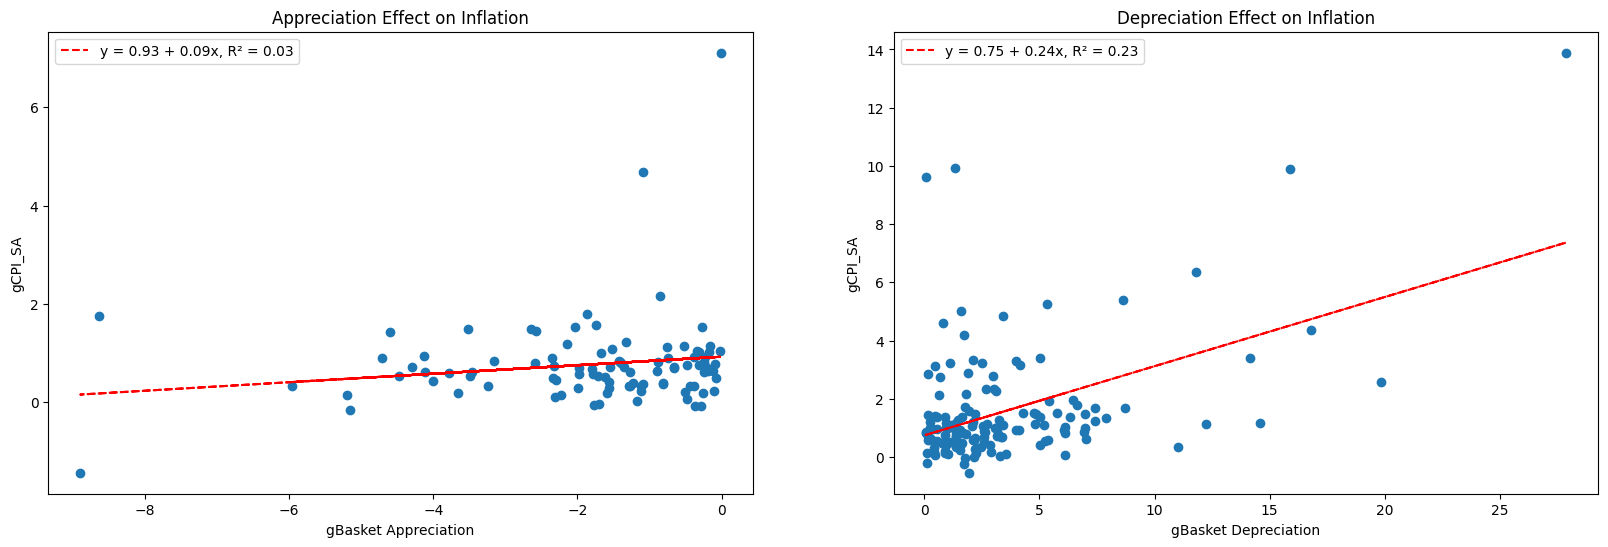

In [21]:
# Define data subsets for appreciation and depreciation
df_apr = df[df['gBasket_apr'] < 0]
df_dep = df[df['gBasket_dep'] > 0]

# Fit the models for appreciation and depreciation
apr_model = smf.ols('gCPI_SA ~ gBasket_apr', data=df_apr).fit()
dep_model = smf.ols('gCPI_SA ~ gBasket_dep', data=df_dep).fit()

# Prepare labels with coefficients and R-squared values
label_apr = f"y = {apr_model.params['Intercept']:.2f} + {apr_model.params['gBasket_apr']:.2f}x, R² = {apr_model.rsquared:.2f}"
label_dep = f"y = {dep_model.params['Intercept']:.2f} + {dep_model.params['gBasket_dep']:.2f}x, R² = {dep_model.rsquared:.2f}"

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot for appreciation
axes[0].scatter(df_apr['gBasket_apr'], df_apr['gCPI_SA'])
axes[0].plot(df_apr['gBasket_apr'], apr_model.fittedvalues, 'r--', label=label_apr)
axes[0].set_title('Appreciation Effect on Inflation')
axes[0].set_xlabel('gBasket Appreciation')
axes[0].set_ylabel('gCPI_SA')
axes[0].legend()

# Plot for depreciation
axes[1].scatter(df_dep['gBasket_dep'], df_dep['gCPI_SA'])
axes[1].plot(df_dep['gBasket_dep'], dep_model.fittedvalues, 'r--', label=label_dep)
axes[1].set_title('Depreciation Effect on Inflation')
axes[1].set_xlabel('gBasket Depreciation')
axes[1].set_ylabel('gCPI_SA')
axes[1].legend()

plt.show()

### COMMENTS: Above plots show that while appreciation has minor effect, depreciation's effect seems to be larger.

In [22]:
df['gBasket_apr'].corr(df['gCPI_SA']) # calculating Pearson's correlation for appreciation

0.1862750028090066

In [23]:
df['gBasket_dep'].corr(df['gCPI_SA']) # calculating Pearson's correlation for depreciation

0.49216340805430203

### COMMENTS: Pearson's correlation calculations confirm our previous finding that appreciation of gBasket has minor impact but depretiation has relatively medium impact over CPI SA changes.

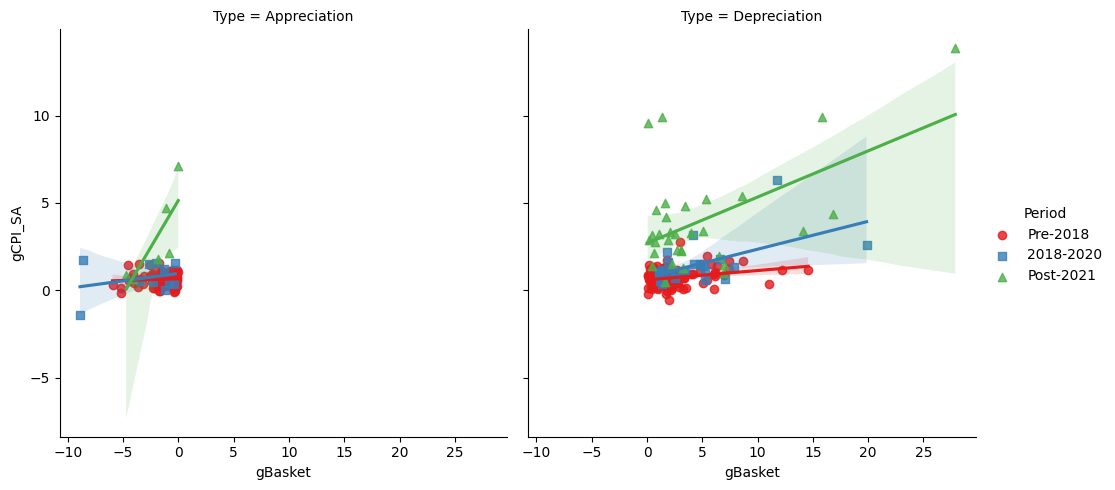

In [24]:
# Categorize 'Type' using np.select for efficiency
conditions = [
    df['gBasket'] < 0,
    df['gBasket'] > 0
]
choices = ['Appreciation', 'Depreciation']
df['Type'] = np.select(conditions, choices, default='')

# Extract year from the index for further categorization
df['Year'] = df.index.year

# Categorize 'Period' using np.select
conditions = [
    df['Year'] <= 2017,
    (df['Year'] > 2017) & (df['Year'] <= 2020),
    df['Year'] > 2020
]
choices = ['Pre-2018', '2018-2020', 'Post-2021']
df['Period'] = np.select(conditions, choices)

# Visualize with lmplot
sns.lmplot(data=df[df["Type"] != ""], x="gBasket", y="gCPI_SA", col="Type", hue="Period", markers=["o", "s", "^"], palette="Set1", height=5, aspect=1)

plt.show()

### COMMENTS: The plots indicate that the patterns of currency appreciation and depreciation were somewhat similar before 2018 and between 2018-2020, but they diverge after 2020. While this analysis offers a broad view over the entire timeframe, a more granular examination of changes necessitates segmenting the data around key events or periods, such as before and after 2020, to scrutinize the asymmetry in those intervals. The current analysis does not explicitly contrast the pre-and post-2020 periods concerning this asymmetry. Nonetheless, it suggests that significant events, like the pandemic, might affect the degree and relevance of this asymmetry over time. To grasp the nuanced temporal shifts, a detailed examination of asymmetry for both pre-2020 and post-2020 segments would be beneficial, shedding light on how such asymmetries evolve amid major economic changes.

In [25]:
# Finally, we will perform rolling regressions
endog = df['gCPI_SA']
exog=df[['gBasket','gBasket1','gBasket2','gPPI_SA','gCPI_SA1']]
exog = sm.add_constant(exog)
rols = RollingOLS(endog, exog, window=60)
rres = rols.fit()
params = rres.params.dropna()
params

,const,gBasket,gBasket1,gBasket2,gPPI_SA,gCPI_SA1
Month,,,,,,
2008-08-01,0.679669,0.001521,0.031158,0.017209,0.095797,-0.041776
2008-09-01,0.668219,0.001894,0.031375,0.019515,0.100311,-0.043400
2008-10-01,0.677766,0.016854,0.028878,0.018042,0.079683,-0.013923
2008-11-01,0.700844,0.014316,0.019061,0.020901,0.100266,-0.073095
2008-12-01,0.650504,0.009748,0.018345,0.010691,0.116028,-0.026351
...,...,...,...,...,...,...
2023-10-01,0.162791,0.109797,0.083217,-0.019057,0.284910,0.403877
2023-11-01,0.149554,0.112781,0.085123,-0.024279,0.282212,0.412447
2023-12-01,0.095984,0.115455,0.096541,-0.015025,0.277089,0.409123


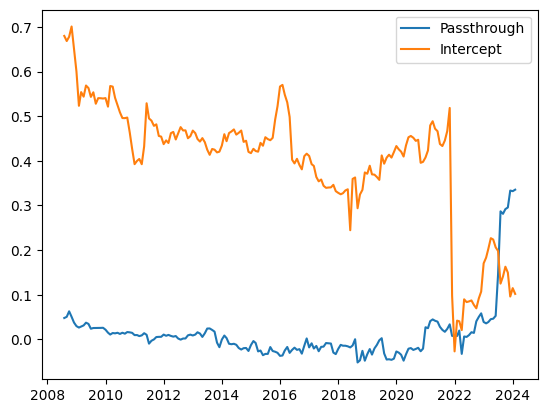

In [26]:
Passthrough=(params['gBasket']+params['gBasket1']+params['gBasket2'])/(1-params['gCPI_SA1'])
Intercept=params['const']
plt.plot(Passthrough,label="Passthrough")
plt.plot(Intercept,label="Intercept")
plt.legend()
plt.show()

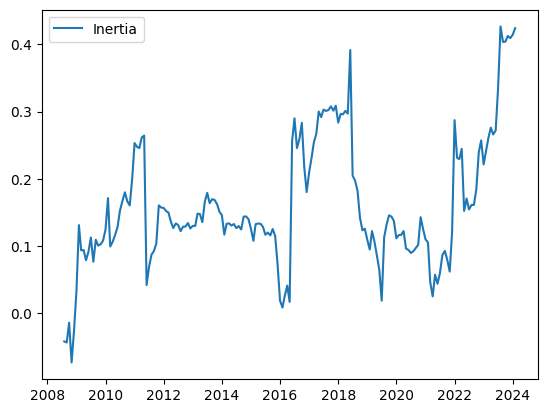

In [27]:
plt.plot(params['gCPI_SA1'],label="Inertia")
plt.legend()
plt.show()

### COMMENTS: Rolling regressions, a technique involving the sequential application of regression models to segments of data within a specified window, are instrumental in assessing the temporal evolution of regression dynamics. This approach, prevalent in financial market analysis, unveils variations in regression coefficients across different time intervals, thereby offering insights into trend shifts and volatility patterns. 

### Notably, the plot highlights a significant shift occurring in 2022, pointing to notable changes in the underlying data relationships during that year.